# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [17]:
import zipfile
import os
import shutil
import pickle 

from PIL import Image
from PIL import ImageDraw
import pytesseract
import cv2 as cv
import numpy as np

import kraken
from kraken import pageseg

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

# the rest is up to you!
png_dir = 'png'
zip_file = 'readonly/small_img.zip'
dict_dir = 'dict'
dict_file = dict_dir + '/png_dict.obj'


In [18]:
def get_bounding_boxes(pil_image):
    '''Returns a series of bounding boxes as run by kraken
    
    :param img: A PIL.Image object
    :return list: List of bounding boxes
    '''
    # Lets bring in our ImageDraw object
    from PIL import ImageDraw
    # And grab a drawing object to annotate that image
    drawing_object=ImageDraw.Draw(pil_image)
    # We can create a set of boxes using pageseg.segment
    bounding_boxes=pageseg.segment(pil_image.convert('1'))['boxes']
    return bounding_boxes

In [19]:
def show_boxes(pil_image):
    '''Modifies the passed image to show a series of bounding boxes on an image as run by kraken
    
    :param img: A PIL.Image object
    :return img: The modified PIL.Image object
    '''
    bounding_boxes = get_bounding_boxes(pil_image)
    # Now lets go through the list of bounding boxes
    for box in bounding_boxes:
        # An just draw a nice rectangle
        drawing_object.rectangle(box, fill = None, outline ='red')
    # And to make it easy, lets return the image object
    return pil_image

In [20]:
def uniquify(seq):
    '''Modifies the passed list into a unique list
    
    :param seq: A list object
    '''
    return list(set(seq))

In [21]:
# get text using bounding boxes (slower but perhaps more accurate)
def get_image_text_from_bounding_boxes(pil_image, bounding_boxes):
    '''Returns unique list of text from the passed image and bounding boxes
    
    :param pil_image: A PIL image object
    :param bounding_boxes: A list object of bounding box coordinates
    '''
    image_text = []
    
    # convert bounding boxes to string + find search string
    found_string = False
    for bounding_box in bounding_boxes:
        bounding_box_image = (pil_image.crop(bounding_box))
        bounding_box_text = pytesseract.image_to_string(bounding_box_image)    
        # split text into individual words
        image_text = image_text + bounding_box_text.split()

    # create unique list of words
    image_text = uniquify(image_text)
        
    return image_text

In [22]:
# find text directly without using bounding boxes
def get_image_text(pil_image):
    '''Returns unique list of text from the passed image
    
    :param pil_image: A PIL image object
    '''
    # convert image to greyscale
    pil_image = pil_image.convert('L')

    # resize
    maxsize = (3600, 3600)
    pil_image.thumbnail(maxsize, Image.ANTIALIAS)

    # convert image to text
    image_text = pytesseract.image_to_string(pil_image)

    # split text into individual words
    image_text = image_text.split()

    # create unique list of words
    image_text = uniquify(image_text)
    return image_text

In [23]:
# find faces in image
def find_faces(cv_image, binary_threshold, scale_factor):
    '''Returns list of bounding boxes of faces from the passed image
    
    :param cv_image: A CV image object
    :param binary_threshold: An integer object
    :param scale_factor: A floating point object
    '''
    # And we'll convert it to grayscale using the cvtColor image
    cv_gray_image = cv.cvtColor(cv_image, cv.COLOR_BGR2GRAY)

    # Ok, first up, we could try and binarize this image. It turns out that opencv has a built in
    # binarization function called threshold(). You simply pass in the image, the midpoint, and
    # the maximum value, as well as a flag which indicates whether the threshold should be
    # binary or something else. Lets try this with Threshold=170.
    cv_bin_gray_image=cv.threshold(cv_gray_image,binary_threshold,255,cv.THRESH_BINARY)[1] # returns a list, we want the second value

    # display cv image
    #display(Image.fromarray(cv_bin_gray_image))
    
    # if we want to display with of the cv images we can convert to PIL first
    # PIL can take an array of data with a given color format and convert this into a PIL object.
    # This is perfect for our situation, as the PIL color mode, "L" is just an array of luminance
    # values in unsigned integers
    #PIL_bin_gray_image = Image.fromarray(cv_bin_gray_image, "L")

    # display PIL image
    #display(PIL_bin_gray_image)

    # lets try and detect faces in that image
    faces = face_cascade.detectMultiScale(cv_bin_gray_image, scale_factor)

    return faces

In [24]:
# create contact sheet of faces
def create_contactsheet(pil_image, faces): 
    '''Returns contact sheet image from the passed image and bounding boxes of faces
    
    :param pil_image: A PIL image object
    :param faces: A list object of bounding box coordinates
    '''
    thumb_h = 100
    thumb_size = (thumb_h, thumb_h)

    # collate faces into list
    contact_images=[]
    for x,y,w,h in faces:
        # extract faces
        new_image = pil_image.crop((x, y, x+w, y+h))
        # resize faces to thumbnail
        new_image.thumbnail(thumb_size, Image.ANTIALIAS)
        # append to image list
        contact_images.append(new_image)

    # create empty contact sheet
    contact_row_count = int(np.ceil(len(contact_images) / 5))
    contact_h = contact_row_count * thumb_h
    contact_w = 5* thumb_h

    first_image=contact_images[0]
    contact_sheet=Image.new(first_image.mode, (contact_w,contact_h))

    # paste faces into empty contact sheet
    x=0
    y=0
    for contact_image in contact_images:
        # Lets paste the current image into the contact sheet
        contact_sheet.paste(contact_image, (x, y) )
        # Now we update our X position. If it is going to be the width of the image, then we set it to 0
        # and update Y as well to point to the next "line" of the contact sheet.
        if x+first_image.width == contact_sheet.width:
            x=0
            y=y+first_image.height
        else:
            x=x+first_image.width

    return contact_sheet

In [25]:
# save dictionary to file
def save_dict(dict_dir, png_dict):
    try:
        os.makedirs(dict_dir)
    except:
        pass
    file = open(dict_file, 'wb')
    pickle.dump(png_dict, file)
    file.close()
    return

In [26]:
# show faces identified
def show_rects(pil_image, faces):
    '''Returns modified image with faces circled from the passed image and bounding boxes of faces
    
    :param pil_image: A PIL image object
    :param faces: A list object of bounding box coordinates
    '''
    # Set our drawing context
    drawing=ImageDraw.Draw(pil_image)
    # And plot all of the rectangles in faces
    for x,y,w,h in faces:
        drawing.rectangle((x,y,x+w,y+h), outline="red")
    # return image with faces circled
    return pil_image

In [27]:
# unzip zip file

# delete png folder 
try:
    shutil.rmtree(png_dir)
except:
    pass

# extract zipfile into png folder
with zipfile.ZipFile(zip_file,"r") as zip_ref:
    zip_ref.extractall(png_dir)

# list png folder
pngs = [f for f in os.listdir(png_dir) if f.endswith('.png')]

In [28]:
# check if saved dictionary exist, if so, load dictionary

if os.path.isfile(dict_file):
    # load dictionary from file
    try:
        file = open(dict_file, 'rb')
        png_dict = pickle.load(file)
        file.close()
        print('Dictionary loaded')
    except:
        png_dict = {}
        print('Error loading dictionary, continue')
else:
    # setup empty png dictionary
    png_dict = {}
    print('Dictionary not found')

Dictionary loaded


In [29]:
# populate dictionary with image filename

for png in pngs:
    
    # get file location
    filelocation = png_dir + '/' + png
    
    # populate dictionary
    png_dict.update({png: {
        'filelocation': filelocation,
        }})

save_dict(dict_dir, png_dict)

In [30]:
# populate dictionary with faces

binary_threshold = 190
scale_factor = 1.40

for png in pngs:
    
    # load image
    cv_image = cv.imread(png_dict[png]['filelocation'])
    
    # get bounding boxes, text, faces
    faces = find_faces(cv_image, binary_threshold, scale_factor)
    
    # populate dictionary
    png_dict[png].update({
        'faces': faces,
        })

save_dict(dict_dir, png_dict)

In [31]:
# populate dictionary with bounding boxes, bounded text, unbounded text

for png in pngs:
    
    # load image
    pil_image = Image.open(png_dict[png]['filelocation'])
    
    # get bounding boxes, text, faces
    #bounding_boxes = []# get_bounding_boxes(pil_image)
    #bounded_text = get_image_text_from_bounding_boxes(pil_image, bounding_boxes)
    unbounded_text = get_image_text(pil_image)
    
    # populate dictionary
    png_dict[png].update({
        #'bounding_boxes': bounding_boxes,
        #'bounded_text': bounded_text,
        'unbounded_text': unbounded_text,
        })

save_dict(dict_dir, png_dict)

Results found in file a-3.png


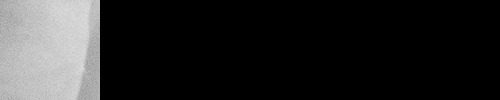

Results found in file a-0.png


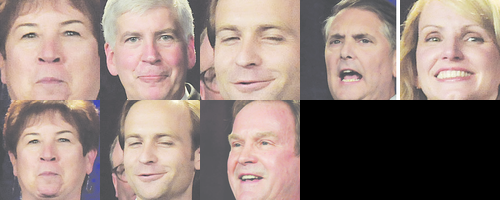

In [35]:
# generate assignment output

search_string = 'Christopher'

for png in pngs:
    # load image
    pil_image = Image.open(png_dict[png]['filelocation'])

    # load unbounded text
    unbounded_text = png_dict[png]['unbounded_text']
    
    # load faces
    faces = png_dict[png]['faces']

    # search for text in unbounded text
    if search_string in str(unbounded_text):
        print("Results found in file " + png)
        # check if there are any faces in image
        if faces == ():
            print('But there are no faces in that file!')
        else:
            contact_sheet = create_contactsheet(pil_image, faces)
            display(contact_sheet)